In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import power_divergence


mag_v_sun = -26.72              #Sun's V magnitude of Gaia   Jordi et al. 2010

## Definition functions

### Model Magnitud

In [2]:
def model_magnitud(theta, data):
    """
	    input:
	    theta: dataframe with parameters to estimate
	    data: dataframe with the real sample
	
	    output: dataframe with model
	"""
    mag_v_sun = -26.72

    phase_angle = data['solar_phase_angle']
    range_sat = data['range_sat']
    cross_section = theta['cross_section']
    albedo = theta['albedo'] 
    mix_coef = theta['mix_coef']

   # Change degrees to radian
    degtorad = lambda x : x*np.pi/180.

   # Definition coefficients of equation
    coe_1 = 2/(3*np.pi)
    coe_2 = 1/(4*np.pi)

    phase_angle_rad = degtorad(phase_angle)	

   
    part1 = (coe_1 *((np.pi - phase_angle_rad)*np.cos(phase_angle_rad) - np.sin(phase_angle_rad))) - coe_2
   
    model_value = mag_v_sun - 2.5 * np.log10(cross_section * albedo * (mix_coef * part1) + coe_2) + 5*np.log10(range_sat)
    
    frame = {'model_value': model_value}
    model_value_est = pd.DataFrame(frame)


    return model_value_est

### Sum Square

In [11]:

def sum_squares(theta, data):

    model_value = model_magnitud(theta, data).model_value
    rest = (data['mag_estimate'] + data['e_mag']) + model_value
    residual = (rest ** 2).sum(axis=0)/(data.shape[0] - theta.shape[1])
    # print((data.shape[0] - theta.shape[1]))
    estimator = [residual, rest]
    
    return estimator

### Chi square

In [ ]:
def chi_square(theta, data):

    model_value = model_magnitud(theta, data).model_value
    rest = (data['mag_estimate'] + data['e_mag']) + model_value
    print(rest[50])
    fract = ((rest ** 2) / data['mag_estimate'].shape[0])
    estimator = np.sqrt(fract.sum(axis=0))
    chi_estimator = [estimator, rest]
    print(fract, chi_estimator[0])
    return chi_estimator


### Markov Chains

In [12]:
def markov_chains(init_point, std_point, size_chain):
    
    chain = np.random.normal(init_point, std_point, size_chain).round(3)
    
    return chain

### Read Data

#### PC

In [ ]:
path = '/home/kero/Documents/PhD/Re-analyse/result_analyse.csv'
# path = '/home/kero/Documents/PhD/monte_carlo/result_analyse.csv'

data_sat = pd.read_csv(path)

data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['obs_phase_angle']
data_in['range_sat'] = data_sat['range_sat']
data_in['mag_observation'] = data_sat['mag_observation']
data_in['e_mag'] = data_sat['mag_observation_e']
data_in.shape

#### Laptop

In [13]:
path = '/home/kero/Documents/PhD/re-analyse/ready/all_result.csv'

data_sat = pd.read_csv(path)
data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['solar_phase_angle']
data_in['range_sat'] = data_sat['range_sat']
data_in['mag_estimate'] = data_sat['mag_estimate']
data_in['e_mag'] = data_sat['e_mag_estimate']

In [ ]:
data_in.shape


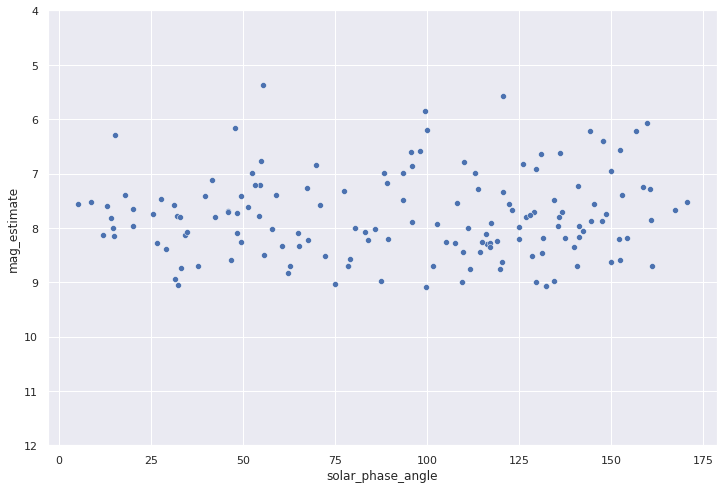

In [14]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x="solar_phase_angle", y="mag_estimate", data=data_in)
ax.set_ylim(12, 4)
plt.show()

### Markov chain Monte Carlo

In [26]:
p_value = 1.8
cv_stop = 0.6
cv = 0.5

num_simulations = 2000

good_p_value = []
mixing_coeffient_est = []
albedo_est = []
cross_section_est = []

mix_init_point = 0.75
mix_std_point = 0.12
cross_init_point = 0.8
cross_std_point = 0.35
albedo_init_point = 0.55
albedo_std_point = 0.2

size_chain_in = 1000
nn = 50

cv_array = []
cv_test = []
estimator_test = []

for i in range(num_simulations):
    mix_coef_markov = markov_chains(mix_init_point, mix_std_point, size_chain_in)
    albedo_markov = markov_chains(albedo_init_point, albedo_std_point, size_chain_in)
    cross_section_markov = markov_chains(cross_init_point, cross_std_point, size_chain_in)

    mix_coef = np.random.choice(mix_coef_markov)
    albedo = np.random.choice(albedo_markov)
    cross_section = np.random.choice(cross_section_markov)

    parameters = pd.DataFrame(data={'mix_coef': mix_coef,
                            'albedo': albedo,
                            'cross_section' : cross_section},
                            index=range(data_in.shape[0]))

    model_value = model_magnitud(parameters, data_in)

    estimador = sum_squares(parameters, data_in)
    
    if i == nn:
        d_freedom = data_in.shape[0] - 3
        cv = np.std(model_value.model_value, ddof=d_freedom) / np.abs(np.mean(model_value.model_value))
        nn += 50
        cv = cv
        cv_array.append(cv)
        # print(cv, d_freedom, nn)
    
    print(estimador[0])
    # print(estimador)
    if (estimador[0] < p_value): # and (albedo > 0.) and (cross_section > 0.5):
        p_value = estimador[0]
        
        cv_test.append(cv)
        estimator_test.append(estimador[0])
        
        good_p_value.append(estimador[0])
        mixing_coeffient_est.append(mix_coef)
        albedo_est.append(albedo)
        cross_section_est.append(cross_section)

        mix_init_point = mix_coef
        albedo_init_point = albedo
        cross_init_point = cross_section

        print(cv)
        print('mixing_coeffient= ', mix_coef)
        print('albedo= ', albedo)
        print('cross_section= ', cross_section)
        # print('model_value= ', model_value[1])
        # print('mag_obs= ', data_in.mag_observation[1])
        print('============================================')


result_fit = pd.DataFrame(index=range(len(mixing_coeffient_est)), data={
                                                    'p_value': good_p_value,
                                                    'mixing_coeffient_est': mixing_coeffient_est,
                                                    'albedo_est': albedo_est,
                                                    'cross_section_est' : cross_section_est})



/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.2820435701134965
0.5
mixing_coeffient=  0.48
albedo=  0.623
cross_section=  1.083
1.7697556722497172
1.597256600453989
2.431549817849716
1.7640458076023984
1.7207333324139624
2.062572074656514
1.976093695578179
1.4254512547759015
1.6074597017755246
2.724586335754398
5.345208132879744
1.1083174964973748
0.5
mixing_coeffient=  0.562
albedo=  0.54
cross_section=  1.262
1.440332553406469
2.0035867886242613
1.264721703066189
2.7072140381339396
1.1636711759080114
1.778316616633533
1.1093479159860284
1.5837476277256266
1.1927453519368327
1.0979903364807415
0.5
mixing_coeffient=  0.555
albedo=  0.668
cross_section=  1.17
1.0557180025964468
0.5
mixing_coeffient=  0.561
albedo=  0.68
cross_section=  1.02
1.084041589643693
1.8967616604163442
1.2944987414865738
2.0948902608830777
1.1492543201707566
1.2587658076566928
1.155070975005002
1.1989085936403239
1.9658252869519097
3.176812349819378
1.3879838030786533
1.889296255904248
1.4490618620183364
1.105443419922983
1.7637792060970727
1.762432976382

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

5.4001749488956206
1.0598543108387912
2.1021032899734293
1.9266597257370264
2.170904792522221
1.2265247491239062
1.1094584143820783
2.7915643843077027
1.7895517767708642
1.8738561533896292
1.2317884723058667
1.7617003824373465
2.0187412378470793
5.335965694850651
1.8456755377546457
4.101700934702925
1.146395811240721
1.5098147879952022
1.1697370409794834
1.1036606720685496
1.6846098671585659
1.5849339568123537
1.639128148962962
1.1474458626751691
1.3079843935456008
1.1413746551440185
1.4481593548589375
1.78071816230117
3.804739911114614
1.0727339900777566
2.542478707681057
1.6787648191294688
1.1725882038827986
4.010151321665262
1.200764748121603
1.1818143777453103
1.054185317801006
nan
mixing_coeffient=  0.62
albedo=  0.617
cross_section=  0.98
1.2401393449970088
1.0535566410099826
nan
mixing_coeffient=  0.369
albedo=  0.58
cross_section=  1.751
1.7657525345502705
1.7680497429719966
1.0960264349128384
1.1782970836820084
1.0588663307758945


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.1466531486598552
1.1183409151146881
1.4006006227138328
1.3574781427902742
1.164756377530665
1.8764619447110356
1.7207659698936268
1.2180549622804835
1.1284830778627213
3.4445532322276375
2.49081500710799
2.59039955966375
2.3115787647477832
3.608555301896299
2.8706933599171625
1.2734629043576178
1.7156483091684027
1.2375442114501753
1.2066304342709668
1.6834827168637687
1.4151535790096639
1.8909266337153594
1.1496519498371462
2.0249495068355134
1.2776055909693143
1.0755766922704255
2.1349324432539896
1.3774899149641495
1.4316798533815802
1.1256486908492327
1.110949074225863
1.3430751630088378
1.9790535241691394
1.9338243459166082
1.4818313570036818
1.490432926918867
1.173857790015308
1.1805804172036094
1.5808845080857266
1.5373152542683204
1.1722518161469728
2.058474465417468
1.1256782009135011
3.6715806613253736
1.2577795438594124
1.6425402697737745
1.8043777781904988


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.97584627231591
1.4015828946817481
3.146808692333459
1.2988005985036297
1.486351919443966
1.7754071436191015
1.8029531867864763
1.757443736136486
1.790735932564758
1.9926019824589194
1.3155943898730893
1.9654684068064452
1.1310364236502681
1.5847953846620604
3.6552716463617596
1.1444000315760934
1.1761905957020866
1.3257463632334396
1.8249149669227305
1.81867259942485
1.1332924152201738
1.09884607045336
1.2056264456692174
7.752873913878796
1.3572291615050804
2.0811447568012187
1.3348031570575194
1.135549273939252
2.4987049726557693
1.141969237759365
2.434473817764583
3.0975198639526247
1.1488027202481854
1.3094840152567353
1.1316818425096693
2.1118200734753243
1.904359029983483
1.1098911309470672
1.2096439383907769
1.7666979486978351
5.092992541642747
1.7737690204118546
2.069416767091234
3.447535519509072
1.1144746412294932
2.5824712603165585


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.7627937599050998
1.9515744523916756
2.446261959542066
6.091328547239005
1.2678521472324067
4.7912730665233365
1.1830838838896613
2.3160695655783208
2.3986541830525456
1.3972417891585553
1.8314159385687119
2.307680382070739
1.3539592119337718
1.2571715931634007
2.224676082208621
1.898524588249739
1.1541689796390926
2.2815201720475895
1.507711060806873
1.677127329301059
1.1010573146491356
2.8923475514392707
2.8798093236352744
1.2498701130999021
1.1612431699553847
2.021949571976756
1.4639507886573409
1.1067290180197835
1.0772107317586666
3.6740710191229375
1.535365684263145
1.4029572232749803
2.267265882736008
1.1860561592365104
1.1343929425274573
1.9172191908831084
4.532375145649097
1.1953667939042028
1.4432262646233245
1.8078200050187245
1.5663613121087498
2.2471776075758925
1.6099836648049384
1.2638986771294587


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.1019679044088386
1.102303220579601
1.5000768094275267
1.3253930016203324
1.1036156004935005
1.750358910115378
1.4302801796626972
1.514120564676028
1.1323019618847867
1.1837047876144742
1.6694473871039817
2.368222405738808
1.1743328010109542
1.7428543531136371
1.1529780670384584
1.3064791734752448
1.7648898183503239
1.05708159559933
1.0883064704250063
2.7800849147976594
1.0971541133610043
1.137690583827587
1.2213330462574856
1.2360101746245666
1.230332688293722
3.057527586577246
1.2796268460057159
1.8001805320753874
1.1018365599606812
2.419057308025449
1.415316026950269
1.22940443254695
1.283481343184795
1.3076061462974358
2.8865708113406336
1.1970556027237416
1.3309980378190067
1.791569388551432
1.7629944150792665
3.2246289674662822
2.469475158661824
1.1529517780745844
1.1287536119358654
1.2106643037456242
1.1874255950466825


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.1146364857590876
2.5954731032888776
2.51007916545994
1.7644591554995979
1.109807130246088
2.327391691484038
1.2029336887217317
1.5691527487278567
1.2487320429395155
1.2027818201117098
1.724669203438838
1.1992897613807263
2.3773497752973065
1.3451617769036917
1.1036420563964575
1.1416223896583877
1.289469631639879
2.3470698508291052
5.481682590431345
1.1395059060176007
1.1131485625893496
1.7155316543814232
2.5126651392116215
1.0913844083055413
1.449626549335446
2.1649547573033585
1.6158669115505855
2.451526302225448
1.2713734460141077
1.0625645427138724
1.680350341329036
1.0997940134970772
1.7719285158165163
1.9280734305995455
1.3125877923473508
1.3525918640005614
2.0458784199894637
4.301519851027477
3.376094902814235
1.1332575867390315
1.1548096057257053
1.5124689564809854
2.060145784492007
4.861590026724914
1.1407836810468168
1.3446575355972374


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.119509354115597
1.1105440437223297
1.3633119015740924
1.1101074598061667
1.1702499721783264
1.572624156915983
1.7728461879242083
1.4625756016519935
2.3034961982283297
1.155323870927831
1.3353483419686403
1.5476996046513907
1.4079411300645543
2.6040538303518885
1.7621435421872957
1.971589488355698
3.348450159374417
2.481646143590639
1.3648893558913902
1.7537707095856545
1.145665432423206
1.1906147136253546
1.6777088469157213
4.815080436002651
1.1570529951332107
1.779808902027074
1.7916103731627746
1.4265914784252256
1.5609248485280205
4.007375870640312
1.1615137682916084
1.8884045679692596
2.633891844234997
2.642727389635986
1.5052250370519107
1.1034611673188908
1.8605932578787676
1.0579309973934752
3.5622521301124688
1.5347055548442203
1.131999474041574
1.777333243021658
1.1372833653476961
1.9336827514392712
1.131008952097021
4.44806358150687


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.1590827687622989
1.642398035714624
5.369613714540137
1.0996050050733572
1.1439472786277727
1.1266259546925133
1.1620089499545956
2.3109605509459277
1.157836259379525
2.0328696103139685
4.492122969057086
1.9068009897841776
1.1955565419718623
1.2027879369080847
1.844073885610647
2.8729468993768257
1.9522968292923812
1.156082371663999
1.2775538736987646
1.8294501932003184
2.9148922915213276
1.2771776458149189
1.7618244678377974
1.222059387557164
1.3796802751010409
6.365786984625718
1.1980612156495838
1.2084495223664644
2.736918706772768
1.2968692988560302
1.9477990441688469
4.3221475937290075
1.8581456500275033
1.4948381667774926
1.2416804441670484
1.7866460641663877
2.1938537769706903
1.2636574122607929
1.5796345994884913
1.2982307854946789
1.742658094086974
1.6009058297112504
1.2775305160584787
1.148469083564396
5.410975192067774


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.2592878502929405
1.762054578288033
1.3133431681253844
1.227118379197031
1.8930470319492343
1.16310642931908
4.1144705678314875
1.333225758490328
1.166379164777931
1.1384950755491912
1.4091973673403804
1.1066018651221297
1.306245024108887
1.3173388899867646
2.003397005490794
2.3174076315009424
1.4299820148564295
2.3780770772487103
1.6352673672370655
1.9488879910961188
1.4594763026422755
1.1582269025630116
1.250723487677049
1.0545658432484253
1.8086038941593283
1.7433089673416917
1.5178348893117393
2.2808538617421608
1.3728364672825286
1.8925784849679985
1.1335022527548229
1.270138788544034
4.683939343456867
1.782033011920083
2.487520578986063
1.8094897271726291
2.6883638767027067
1.2395706836471354
1.4001784721321813
1.6363723325197221
1.1919563176699954
1.3700103472490825
1.2317342542874714
1.435200976419962
1.7214720207118557
1.158610419811941
2.9426036851771156


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.1024642830412148
1.7182954913032205
1.8862905119250293
1.7855570133262846
1.136979867650026
1.1723576411893013
1.6224964594601181
1.198050879699904
3.824708382822101
1.197703073145416
1.6406523787215535
1.8938971459552099
1.7830751033466175
1.478533136043874
1.1110396709870058
1.5499774468991354
1.366861076482921
1.3129498005510112
1.150026791275817
1.3338075023451454
2.102633642132587
1.3153816373495404
1.0628578417179997
1.509848042538833
1.2947527339689493
1.521429554088458
1.1290420263439849
1.274190411467843
1.8381057197987132
2.838251925213116
1.8525431235921057
1.1006692413026251
1.4096321131659186
1.12782196575944
1.378244885290984
2.7148683891062677
2.6474441892769236
2.288336894400863
1.421318133012148
1.5431358080768947
1.3902592873578528
1.164357833215623
1.6238392876998002
1.80302820908998
3.765082837017932
1.7822113628853
3.05871683058402
1.1447088475490872


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.7019847691567944
1.2844878075003376
1.927591018229619
1.3813814508002216
1.1617743238710139
1.212932196525499
1.1926661589688106
1.1293619224494813
1.9572850709118725
1.1777539801572172
2.0651440155328236
1.7857503180569558
1.77964347685151
1.8018031411160753
3.4969119795162933
2.7562769597820593
1.8136258884068657
2.8550301519538883
1.7856664385422318
1.1332881173320948
1.8009679444555604
1.1197430038485474
2.02327528326523
2.145915603288406
1.0838461531361374
3.43718733553047
4.304567655118717
2.0234661378619103
1.2993612046088931
2.506542753044462
1.2114020645112058
1.4557862558446695
3.4524574057097013
1.1743171999785214
1.2581833957579338
4.6702250216984575
1.8658411414434628
1.4332407274402255
1.2489595307430374
1.9762408900307267
1.3209040414708075
1.2035204358791367
1.2691088705633475
1.316674544480181
1.774071062661974
4.411638956816328


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.8864147097862203
2.6970862411558048
1.205779829941747
1.1547570771146163
1.3392934703967638
1.1417247859565975
5.822354529974829
1.4100323489765767
1.1061059301461469
1.1540707855136785
1.9248189691898812
3.6738366611944255
3.00578446391435
2.2270834975950833
1.1781762731035779
1.1875856932108688
1.7786014502263912
1.9372462413480498
1.210494832343583
1.4159249213928986
3.4981021306042455
2.79876452356562
2.0828473359110298
1.5427355892424932
1.7719369932328815
1.1497900241772094
1.466678428069679
1.2380864128817481
1.7108295651073653
1.6808124250678065
1.1548129508523808
3.299560427258547
5.859987899422064
1.7358073317916005
1.223811156051599
1.5089245745184938
1.1360305219207487
1.089052075635854
2.7150659515974973
1.9077567061465257
1.7656907087273903
1.7628779601568185
1.3033063385678043


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.2374429230942874
2.0191865346690565
1.5494773149037948
1.8576304568744502
1.5315792170183034
2.0047535079200083
1.446136040475588
1.103334048957144
3.2837939181202858
1.3791071171598037
1.1127563192402903
1.5864572734618787
2.068590763675177
1.5885170300753175
1.7729682904974067
1.1386045497001538
1.1885065524081975
1.0603705132837413
1.1042537511653148
1.7848796011517205
1.1016593386532212
1.9784391932443224
6.550583601952543
2.8364881805878577
1.6865251419898781
1.1369326579722903
1.9979842429543488
1.8122149926994715
2.572055391610106
2.1168794202461423
1.7777002896644944
1.8611001324926473
1.1107121333029693
1.4767187789658787
1.4456423361079578
1.6233292971094977
1.8927319219547352
4.320186289661663
1.6333605535133533
3.533869881391838
1.8883286235788237
1.0990727944789787
2.1710356576612266
1.2190463132590963


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.114976899874503
1.404448722344082
1.17440951644902
1.9017890855991615
1.0851232143876983
1.1855066676284063
2.2933206729455047
3.315570393567365
4.142021816500786
1.2840049114805934
1.6316509635487626
1.29345974577363
1.837480523361698
1.2527359694555422
1.1575526871303738
1.7751858036826107
1.1480741761547593
1.7318921269814516
1.295844496087765
2.2355316310650992
1.8187923819849459
1.1567779961880684
2.3565388224226798
1.2891372252697375
1.3155088129995487
1.76832895449246
1.130836773573785
1.8448485799024459
1.1125295728085312
2.188259499846987
2.972297585740252
1.864130918990609
1.7950010758577486
1.7099754398895815
1.3323594477779839
1.1233680709572482
1.271500462348926
4.9639199928195135
1.548773863755858
2.6085026848115693
1.2279375582738852
1.2718149949875692
1.8899091332397684
1.9020616746018097


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.2139365604410353
4.326858171909998
1.305800428046738
1.8230886682687715
1.7078424042325697
1.2538383287179076
1.8478137443869824
1.5287029214119565
2.0490089249462997
1.2579443223328821
1.3195717709742723
3.5307075639748895
1.1522569935276248
1.6531362288045943
1.1068347877484495
1.988161363323175
1.957338138438203
1.4883233003432743
1.9302931105432752
1.1942588024386611
1.836018007430761
1.8384207180397727
1.2434873404161175
1.1788103226265974
1.1117043378419837
1.1789863618936778
1.0950744202179583
2.9410750894710915
2.1121842084826947
1.0545188249768354
1.8111860342572808
4.70512926764329
1.1457955662487973
1.1063605259417058
1.1311641609441858
1.7677339992972194
2.2744429736794793
1.125109071159583
1.1603805652126533
1.7457520049209618
1.8810200387852798
2.3760920385017554
1.179132947243169
1.891949276309408


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.259602515069595
4.977750355520042
1.3181548729688777
1.1578259300763674
1.7501548411772423
1.1194786127040615
1.110507445779907
1.4755035486185224
1.4700691294664943
1.1529492130315746
1.5600083611794766
1.0911245850520062
1.656106627195931
1.3145667615899617
1.2047528844727253
2.3212468322702864
1.131915408634898
1.1337408982828048
1.185977891529714
6.404452209997565
1.8970859325475369
1.0878444046551363
1.4447415700738817
1.1452482690182424
1.1117090392586693
1.364636170921977
1.5903234904651724
1.064146497715869
1.8110677928687604
1.320938451288257
1.1690362554900644
1.1264662303473711
1.4353048254194756
1.5902947699767975
1.518141127474324
1.3217171363581266
1.8041364494507979
2.1036636207485695
1.1054463435523063


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.8342242789370247
1.1333446397005722
1.962798375745662
3.499432394916551
1.108197180239704
1.1242713873158297
1.745711717928261
1.1543751007520437
2.1392575188792793
3.9868160347145944
1.1284994505130805
1.7450182798080096
1.839812694849936
1.1351721043549676
1.3633479335753158
1.6101197037666057
1.374768434265142
1.5751248309816013
1.785492347338985
1.2829248611153612
1.4855247482074014
1.4960869303104616
1.1290167263897346
1.8041095742956803
1.360267374630958
1.77154657721433
1.316111852759453
1.1816931951566412
1.7019211531447904
1.1521348457932332
1.142703194656502
1.8418187432153394
1.1293194050386355
1.1573339873481803
1.1093124514394355
1.783207217928045
2.0882028014039657
1.2143582393776573
1.1913728853321284
1.2304977621081847
2.6047522386268795
1.82186437256824


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.2478367741771694
1.1060761961912562
1.3145675614263324
1.1039378288885016
1.8116717545189875
1.1471386654712372
1.1310915826265178
1.3325823388880094
1.1653005218201604
1.0630559175226506
4.4575224026344955
5.798470252422469
1.209085901054168
1.7462325376709937
1.76879830305664
1.3485335762474613
1.7069365686152176
2.105581118582749
3.0837457783397584
1.1687681452769554
1.599669357343459
1.8282633303698228
1.3860343895854612
2.0773631560992776
1.0925311420173986
1.10745083582629
2.3144414761668637
1.3580330577333255
1.931770381823307
1.8067073563585208
1.0820134881726802
1.5692755067946542
1.2314360924515142
1.6475180759884132
1.148503487598249
1.1139034305477116
1.172718754889761
1.1643271449040236
1.387876027008738
1.8508440055504016
1.1678907885977385
1.7929263853181363
2.234628206389104


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.6509700983523647
1.3601784132853627
1.1056721703667334
1.1522109350116543
2.683941040640823
5.1903949625856525
1.9517767796079604
1.7056560622866281
1.129080778322366
1.8420309945378148
1.194171537340486
1.2816960776110327
5.040572498803694
1.1009038727056877
1.9878686344384866
3.752209712122854
1.154363350474699
4.186467410846069
1.6880216408547544
1.1504276007847323
1.304031138562378
1.559829740786573
1.9954766588409893
1.1050175187074525
1.7629902286205241
2.1643889653001884
1.4683656220954457
1.3786601220517904
1.0720580260268409
1.1955397372555112
2.6726932158481134
2.241576105936893
1.1549582440684842
2.307505777598008
2.121332079487099
1.2992930891618482
4.175240983170765
2.381205431353528
1.3654404181657436
1.1674197541485556
1.169963657055648
1.2841920096323853


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.7680845354678911
2.8438077085348197
1.2248571395632757
1.1786090704212577
1.9756355596541562
1.2546150592482987
1.5145448233438765
3.9451752458928366
1.8326748912950508
1.8477356123148199
1.906015024601081
1.0796283818872554
1.413844150357334
1.7157764110782945
1.6056524362641393
1.9238499530881898
2.533352725844396
1.1469397738099678
1.8784801015512333
5.329174092395445
1.1712915309157246
1.8400623796682254
1.9488180799988035
2.8479307764137536
3.3813281107738913
3.852091665520171
6.331714155021235
1.6021724590844078
2.0067842655735166
3.0463229948197927
1.3027983267246062
1.2815108769754893
1.7059108079718244
1.789060219510294
1.289911773190881
1.7643012936681766
2.166593509347138
2.0832831905750995
1.1033041441422817
1.3999192241784215
1.9605494192746786
1.2202622289266976
1.0599363664589385


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.4236113102576478
1.7411399081328518
1.4253123763767224
1.3621997018723835
1.831094572259112
2.044212158005111
2.058306490019194
1.1161335449577925
1.153429864140517
1.6248702515823763
1.5213053768134717
1.8516009281134092
4.518480228928884
1.4690579144532248
1.8883156299360795
1.5103993155943451
1.9202038602940905
2.15987333989269
1.1807005592326016
1.1333373193913638
1.2665821237129629
3.3886873822518053
1.3851513465556813
1.2522295298315276
1.905504334531583
1.3733568725473726
1.4336462694336436
1.9514367212725865
1.0949598133871445
1.7457873414699252
1.4580633381809138
1.2021138476499071
1.0980769820472125
2.0337477500052645
1.4951239619080214
1.1064191091377444
1.681549627444166
1.1638603596248605
1.9678591388054587
1.6818217917271117
1.1174731864337755
1.1426353492375374
1.4509965180014803


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.250365012988312
1.2616451033372516
1.0709727386408339
1.3471610947761372
1.7258974891662906
1.3387041054728661
1.674836445918211
1.1151144887787467
1.1063227512416003
1.4021162979273014
1.7625258479525558
1.8257249191711058
1.1228916633997177
1.1102028930099916
1.8708299610313028
1.4861241034071733
1.2415829257666189
1.5422214221266193
1.766644391097334
1.6497039989381361
1.782505810511083
1.5661548720475609
7.723384792598498
1.7075742740254625
1.5495651974731366
1.0538940774916687
1.8558502858836916
3.8295308812388256
4.350842065166535
1.9146686434556157
2.191795621956471
1.8439441590100103
1.8119795259287796
3.083163917677776
3.31932744506272
1.0983815836857354
1.3872258812784477
2.127519318584987
1.1329639896989856
1.7673682074035881
1.2711835338298567
1.346671138934554
1.708782984440372
1.6209440909149384


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.177038280354892
1.1509271455470507
1.8928539834663693
3.6258255096388736
1.6582705864679343
1.3332426374568647
1.265451819429791
1.1999184190052585
1.107824611761977
2.557443491234642
9.140765394878246
1.896504404106916
1.1267700183500011
2.5290701250400405
1.5473260656115773
1.1104798283319488
1.4268452114621994
2.1758848960593893
1.9441524531970924
1.3028858138363828
1.1309648053431138
1.7307714288204767
2.427203045445071
2.27618819740258
2.454978975620483
1.9123040431244096
1.3944346331805455
2.766443988520614
3.3480824426143663
1.6199595451027147
1.3411808631879538
1.148009382862184
1.829879573237404
1.1059038374883072
2.4788821994624786
1.9352521318136047
1.8270083856159551
2.0164473547726214
1.7693247280796114
2.7258788356838357
2.381236631870208
1.7817489698332432


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.7914881451725926
7.315797746778924
1.1567249742736057
1.7774613994966921
1.09730707298062
1.2415204167198417
1.8283693601020388
1.2740145459513725
1.1180042030927742
1.7679105902054206
2.422453069280098
5.368971106750372
1.2503457644628204
1.9425114419688074
3.6224979775815003
1.4382382215872642
1.161218544630987
1.3907180556769128
1.4832514409652895
1.3941839967474055
1.6823015931673884
1.7802551056626958
2.0942665370337763
1.1688621023389913
1.5141283253801154
3.601503109742086
1.2857370725823931
1.2902925329774029
1.1208693337888314
1.2989028887306031
1.0985434917796684
1.4467552251515055
1.138011289078532
1.7000873634003864
1.1597542266127463
1.9902177198583832
1.2063965553024256
1.528998032172631
1.3942515410009408
1.2380247328448188
1.1355142488368544
1.4638414301690899
1.1825102816059823


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.1418273252080462
1.312166917513932
2.067031774722427
2.276194697328648
1.4269893222810872
1.2200416905148452
1.2532733718393247
2.1127513061950753
3.95266798304726
2.2528559634386833
1.7535306049524997
1.160332610868459
1.9542025844371842
1.224633794308626
2.2590812626292123
1.3177296890792076
2.2167034186134367
1.712565595766602
1.422015993851998
1.5021198875221393
1.5448694460371832
1.1613281838961207
2.0905270468090804
1.122778832051302
1.6488968847986476
1.337615291341335
1.5551581113314317
2.156151539875095
1.094237718581797
1.761799223813705
1.1104289305873731
1.0945769785334991
1.8890420006108726
1.245968208712803
4.225098799589442
1.105926880479125
2.2099054101126177
1.7776714343409727
1.7406661764335647
1.3133879857299484
1.1419399883207464
1.2791284309722026
2.10720511727385
1.0823103647036962


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.1463104469809695
1.070429539387609
1.1858064299046878
3.205698735085111
2.9336909355434417
1.4851455193252725
1.072115896713393
1.4208149281133373
1.283633377730152
2.14820244128369
1.1246174776026674
1.1791740854982777
1.4983222091875423
1.1336882895474059
5.572225391477857
1.8095305864949067
2.1981435033324077
6.133657526219653
2.5642335608348366
1.7882677652173877
2.0046808898932658
2.06074813966179
1.2984770790216125
1.8879053928656926
1.0667157124696065
1.1034760388959286
1.2768507302274423
2.0268382906748785
1.1442452666935556
1.1439407526768124
1.1370578030150267
1.056895845229883
2.1058046659991043
2.152436369884347
2.7687258267094115
1.0948137658666848
1.7829011102269503
5.792921901259637
1.957521636055336
1.0740751576850793
1.7006644082977884
1.7709861966596159
1.3889461229343953
3.276879440924933
1.8123894579595086


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.110248387021599
2.0406349635135106
1.7564373404888203
1.289123327487031
1.4610771068461854
1.121232089642214
1.9074267745326074
3.0307194214524924
1.1181822656174865
1.633877430028123
1.3809187013090012
1.0737556978706415
1.7789304691213457
1.8041124392054575
1.7820463091452
3.319074058604727
2.3418651603878495
4.3533690800160265
1.7647198204757535
1.5075478445287949
2.0013315610974294
1.124486273001854
1.2324723026085636
2.426101634469456
1.076402036544576
1.4556778461294206
1.6968624572355238
1.0657734910338899
2.3540105096788917
1.3394637273333219
1.5548371778337438
1.498792155513435
1.1277088130723159
6.056975678210408
1.4922716388796238
1.9815263914123098
1.1015162703339834
2.8552278495413104
1.2829099488088547
1.2027825546843025
3.1662378653474903
2.226189536234332


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.8139642784298475
1.1657687077542849
1.8031222116531684
3.0511872504218687
1.7460134804655674
1.4472216047856894
1.1549399998224514
1.7936929081615836
1.277523725838791
1.1290619370871673
1.0994545258740387
1.827448000412208
1.3758086447473938
1.4432379239582471
1.301835871597624
2.3671429892032694
1.4149492543595148
1.7618477367688916
2.1780082265338128
1.165588582067157
1.164920619452479
1.1341474731199217
1.8581187472332463
1.1307813169851275
5.2587720830898625
1.3030509892197666
1.962577679490099
1.7977454215658408
1.2058036591600094
1.7696464345611191
1.143412037392929
2.3588138267997665
1.7726652272281735
1.6898416339434827
1.372481046432436
1.6448940060724726
2.8084266107128877
1.193830025452147
1.3719136741945246
1.764697349121817
6.214456211056773
1.1348446117691462
1.1567905878530624
1.3919861505326534


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.3354522194388396
2.902391860198619
1.7359939469501444
1.471443695779205
1.2894143949752828
3.258727378669981
1.7660254946050744
2.486919432649716
1.380810135272771
1.1865195492976852
2.0788742487166774
1.1795056576077232
2.038039911750869
2.0616440488954777
2.018746743997935
6.697726200094302
1.742266726188252
1.1112643334115946
2.378483134553836
1.7671162007788743
1.7625315795493843
1.127354319680733
1.3121457885967958
1.1811007958691428
1.1048156390963748
1.770384367150245
3.6396710891319404
2.3804218514088964
1.2970907669339495
1.105472316926142
1.175233665290653
1.9508558087448946
1.801623548475525
1.1085981612516569
2.203729591877778
1.9303970511164945
1.2086485259033737
5.031276155905141
1.7800780912123437
1.5257144975506336
1.6214453426931392
1.8264451741412582
3.151664553707215
1.106100341859795
1.1089905924487131


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.4065906591872956
1.3921750986520485
3.9914561453465978
1.1259661312989337
1.1483405222979486
1.6004729791397727
3.1725894967237096
2.826502839384852
1.101693278891335
1.7541914946013981
3.551425999392282
1.673782061442408
6.790882629249987
1.2084184996961445
1.5351665368053853
1.112101278466109
1.9740799131982385
2.109669541699635
1.6059683415100738
1.6882258839042448
1.2546155718670808
1.1189741404208402
5.308628628213097
1.7743859677010287
1.2125574481301327
1.146939964957403
1.3104569618289905
1.7634000326152792
1.254713162336864
2.3048976781354957
1.3879092798147692
1.4237371064235482
2.914590379804222
2.0100449767640107
2.073695521514184
1.1020053785688908
1.3160020506067696
3.9720601334256234
6.119193536098238
1.0660962360742237
1.3740172713592096
1.2017013123774674
1.182335198701504
2.03292341639245
2.800484351655321
1.064956058503927


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.1067475595859473
2.0255317102235084
1.2838871525745796
1.797347811080045
1.6945959881692745
1.918204110153024
1.2727205961307435
1.0983614713910876
1.2791126172266114
1.8207058289445246
1.8098272204223977
1.1534906795659905
3.0962919342595963
1.8117211596021472
1.1110842937126328
1.2067350095078477
1.2946413582475587
1.895848321882811
1.0532819377175802
nan
mixing_coeffient=  0.366
albedo=  0.404
cross_section=  2.534
1.7103703548930658
1.392597949843326
1.5876517501664906
1.9655934759559361
1.1439665311461416
2.0990043235523483
1.142436986158747
1.7274157316677234
3.934348826539754
2.766378678709166
1.8206277794021672
1.8747784660235147
1.0562491689096247
1.9482085017789854
1.1834321707086313
1.30316270130385
1.326142934020127


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.8008116498519824
1.2507500194882057
2.3568164687345208
1.7402123768565692
1.0859856488591833
1.935607832854156
1.0598462696298083
1.0602915784188611
1.6282144089697292
2.433017808001445
1.1935667086069148
1.3181569939815874
3.1443561739656096
1.238047025850716
1.213825471312242
1.386507073881477
1.2084463672907597
1.17702025664105
1.1394009879718168
1.0798755562485762
1.4648473332941678
1.1243606285861107
1.3727083453080147
1.6348527387383545
1.1119290119089857
1.1044922479265598
2.1297701912504947
1.425491504553953
1.3507398801535184
1.2990351502713606
1.1531456335809531
1.948400297883646
1.3408396100364917
1.1742113164206716
3.728133684213568
1.3685829068865212
1.8072317962034348
1.740109226203268
1.9824278295372946
1.3370955893425118
1.4626482857387202
2.3871374338146825
1.0904164258987568
1.4472709171899254


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.6365771653765695
1.0666323286674306
1.1159680404700252
4.2260072251864
1.45761172141385
1.8166179005639242
1.1072575619595237
1.3676627208611312
1.766651005401447
5.458021905377965
1.400748819104583
1.1206555887106486
1.831395980110642
3.3972810651375576
1.6196214101211241
4.821066400804476
2.048570268302138
2.0941174232230404
1.2928128750846786
3.197109678092568
1.7749654697810882
1.3997250376997004
1.2952213226879827
1.4514771000973195
3.331078283543996
1.1250087874453127
1.7203743446256539
1.4040211898107073
1.3326048471320056
1.3053821609592837
2.7729274905901833
1.690152747772812
1.0633109376443863
1.3936229102266333
1.8090216655055995
1.7617733781015255
1.1594115486333798
1.1105173818593714
2.244770558640951
1.1503942224748436
2.0059848823004205
2.7553128703219634


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.931633810932228
2.7867982411511596
6.205069114840332
2.9384816953136323
2.8274989618802038
1.268284700779227
1.1264281600583832
1.866110393703404
1.5944552963644238
1.0927031439361585
1.512332796444608
1.8182303849543615
1.211448453553425
2.0725457785721955
1.0911849103725222
1.1424589879787865
2.7205985694788133
1.4419264861357721
1.1634629063144037
1.320500459496321
1.6105873125795953
1.536746256856784
1.1657741310522818
1.402331317333092
1.6398112536638942
1.8403819280887235
2.4908634025969034
1.7659803377550634
1.8434718354390212
2.251062706903514
1.6819980559120968
1.1398892498674122
1.703179715636884
1.438555281098985
2.3781079046332825
2.814904161203663
1.1284487021331124
1.6577739686962565
1.8622150616286257
1.8999711533174541
1.89773304884073
1.276942913791415
1.3833619973798499
1.3787367773081614


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

7.961996298482851
2.3964209414759936
1.6758533066541341
1.1415747478512142
1.7623188837280659
1.773017201933456
1.1396716348585785
1.1309193285365278
1.1995138511621621
1.1759332606733048
1.9206653701416279
1.130638592976752
1.6832189128074093
1.9410297978341027
3.559702054836662
1.5513733133554957
1.8847452945458882
2.822918599455026
1.2335151257616377
1.2128468337216078
1.809957670751994
1.7973389630525802
1.6741393722296187
1.6686223529601723
1.215426421107274
1.8023977537784712
2.125667566793712
1.2283745268248845
1.7935814568784758
1.3510891334089659
1.4928130374990027
1.8754333364697138
3.4137946979990073
1.103369749816012
1.173824996613732
1.374908133353486
1.321773788199455
1.1429225592665913
1.3828281429106675
1.7616595711715357
1.278850704620131
1.1387314418114138


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.6369116448983867
1.7474769004408863
2.3512010931192204
1.0986667048792276
1.8139462714707943
1.7494958266207263
1.6470292948059224
2.320387714438065
1.2760647020964189
1.1601257790635986
1.2797702296781759
1.2837228213654703
1.9881193526426697
1.1244363303900882
3.023509770789337
1.3917831841930062
2.822735814694622
6.25710033019703
1.2181007543515077
1.2561291336786335
5.720856157406456
3.114091644114792
1.7368588669620473
1.2694628380506336
1.3643420553549357
1.172942321047795
1.7731368292461922
2.2349232083217108
1.247058145045557
1.2489102608641232
1.2293088562249823
1.1271035086607166
2.429346267981643
1.7617373313259124
1.7723494241916837
2.0909323768127117
1.3046301272435492
1.6812910638415113
2.0268412048127016
1.3193284127444267
1.6897925874029929


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.6641940088978604
1.8257811781602025
2.143331500454496
1.872755102507073
1.1433901826689237
2.982492464293439
1.7184952095122068
1.6052405374973595
1.1578156337151415
2.179875702551327
1.3654245782165597
1.6561713748360807
2.9111156222702794
1.342314862720726
2.2783498366369943
2.5112910195426545
1.35987478453568
1.330538458272635
1.348007958595852
3.694985137938373
1.3363834427012284
1.9671430146271223
1.3544960672858133
2.7476268188011783
1.7908382225609578
1.574050964411988
2.0726502476318722
1.3066128840636861
1.455929389632075
2.666051645656235
3.9398723532859874
1.764795181699867
1.764037952131031
1.7683077855940263
2.014012449123503
1.1530951175695259
1.337379012933733
1.6276083318973762
1.7870275597859873
2.8975132393251783
1.8845090303024439
1.8630034757072869
1.810065705325654


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.853645685699158
1.3169812389470568
2.0568332045785667
1.161277469795785
1.9433490306958594
1.2496019309923994
1.2966758144020187
2.0871893951505456
2.404903609979337
1.387512191049964
1.1979760539449078
2.683143901499009
1.4312453660900555
1.227801223795272
1.7203130776597555
1.3341964070236738
1.677078924848839
1.1140681648333572
1.1884721328574652
1.8494564479739195
1.6514594944423648
1.8138210266424706
1.3137269428513394
1.1881365465662372
1.763137191302035
1.2943254367079515
2.066620862868232
2.2207316600982945
1.2322169324110144
3.849900248603785
1.721783917942331
2.0101660581548173
1.1072732335293038
1.1576268604210997
1.1338633445386495
2.3045356490187636
1.7844453132439766
1.8020400281638524
2.037477362887743
1.5319685681737332
1.1568930164090425
1.90769629767342
1.968467099560397


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.710272270654743
2.3681604333851527
2.47451735997375
1.13132838622761
1.1073483347573023
3.1683305593460664
2.040850167855382
1.3769187488755705
1.1440920529355023
2.4861932804481013
2.1919795715125376
1.3308845679666184
1.501001496153118
1.2113091359941166
1.2926352917300643
1.5336175926343625
1.839310614215563
1.0982565981523436
1.2472280876611412
1.7675191577475289
2.5641451344837645
1.5463022276326055
1.0758509366606237
1.0542885348698696
1.1012452695556258
1.830352358040023
2.034722703802928
1.9081798273181274
1.9344461405030835
1.6459508293437808
1.8368395057667628
1.4002053108209191
1.6115164831386686
2.114556750465238
1.4440965716564889
3.8923469733878857
1.1542143542739165
1.7616425691712911
1.809894638893608
1.271257640541232
3.2780393459607318


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.384471035843801
1.7054721411071911
2.4103036438464973
3.271881561152564
1.3463368536473628
1.8512906057092766
1.5825605951996118
5.306529800474386
1.1139926898856511
1.2790699367412048
1.1624220943245946
1.224619818088371
1.4038280001770744
1.0506420796839209
nan
mixing_coeffient=  0.346
albedo=  0.422
cross_section=  2.562
1.6639027867371299
1.6117366607505577
1.8991788496371902
1.763748272786284
3.890169411757063
1.2202015701487265
1.7830129616041581
1.1262067043383392
1.9405440992357588
3.040292859691502
1.7292331111715404
1.3630804300594679
1.862636639248362
1.1389632234438856
4.466282609686836
1.43791151082159
1.8263594707481532
1.1587825521314967
1.5125966561633162
1.7815710013575943
1.2544656277646962
1.8469464741355728
1.6873615060486669
1.212908496589348
1.1562634158433576
2.138250337320686


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.0720830545129794
2.4499145959837456
1.5845352857794401
1.686829810810173
1.0702952667589845
2.7407839997010583
1.0746897490351528
1.147780878346949
1.1273616555171766
3.0259798876549566
1.7752431189792024
2.811006174059117
1.3176180502369503
1.1785163296395686
1.2305155145205204
1.5171899697540374
1.8221343721952352
1.6612923889090345
1.2040421476586025
1.1414944539187397
1.1232880630613646
6.215064997493787
1.6997735440031245
2.0154808850076043
1.953243678009009
1.2447024336631853
1.1028410892930094
1.796768610995515
1.990112977289444
1.637966396364616
2.7348881434242553
2.181370703991824
1.6546977197775858
1.1084195200092095
1.7817101344796047
2.560080122625662
1.2257716821792366
2.7255094234767068
2.674243872829571
1.746865173431235
1.1483165237552424
2.7301284217397144
1.5180411188638452


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

1.8508037087256028
1.1377966779802802
1.1324447290937834
1.499344358010824
1.0874981620971003
1.6045990957384175
1.8249032890824344
1.1224785415921807
1.3890173026701835
1.3001605410180639
1.4710224235559624
1.3484802574162693
2.0103219279450704
1.8890885376897235
3.580830964687562
1.8360579028163926
1.4902253937678291
1.5350134841680865
1.7300074954816056
1.8181900494696472
1.660783203306963
1.3746427107652728
1.2734271943595172
1.7645068841189795
2.292804980646524
1.4537925189090597
1.1490550608441104
1.237442325950244
1.8414910085120495
1.7947971270421192
1.0749473037411477
1.7667390304826693
1.4154944945428258
1.35064106033032
2.5228700687321437
1.5975847095724582
1.3493297775023911
1.1527455918352585
2.1434495852540194
1.152655602097255
1.3825809903399662
1.3560393251258251
1.2304851525872222


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

5.2636412568396365
1.7656153644547576
1.189103018016755
1.1595060541361788
2.2462508879235825
4.443406417628366
1.7617237194028055
1.6068541042242472
1.2766709412278783
1.1118675024459383
1.2409286993418605
1.7867962006766032
3.6907654759186
1.7945457347279703
1.8238763523245995
1.1627414996699958
3.3639004570066855
1.2482596945226005
1.0578590346708565
2.2393196631049426
1.688493252625242
1.2670073161577138
1.7673200723741367
1.8107520040698653
1.1718259515292768
4.555377545442667
1.2019935083215687
1.9026713228899603
4.23181609889732
1.1014121825882406
2.0906491195352244
1.3317613706586318
1.7454196190076605
1.2366218889906837
1.3894581410098186
1.8022058252167996
1.1067173026361128
1.329555385812893
2.153131720409777
1.1173266561757473
1.2069634344640652


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.1971387377943015
1.597369499224456
1.6453526326773729
1.3731523661575906
1.6346837510726455
1.791713780522984
1.5128628896998575
1.4321078751176461
2.4722360673107473
1.2334334056549054
2.1205773889239077
1.5197622589559903
1.7666395778749577
1.7853221030302957
1.1524348650495537
7.806676530049544
1.5679024290254302
1.861230851662733
1.2658505129882534
1.7397143960586519
1.077141556661044
2.165859063436001
1.7620025198220275
1.8245002425804662
1.2171039348505586
2.812728313255576
1.093872872199284
1.3085161489608694
3.1044748378147062
2.1006951629750947
1.216951058035303
1.1949477556096095
6.274005375089204
5.552020644321264
1.4113964011538458
1.2258252011159072
1.7953091125651681
1.6649435542333286
1.1633214527320923
1.4498728685524471
1.4401133810746025
1.2128020510000874
1.555702118698154
1.054545593404586
1.3455809529896552
1.1821782313684988
1.848058032984579
1.2336778261939159
2.0067045464617705
2.7938925539648687
1.4052161310089288
1.7789636590114655
1.1763333775579583
1.80285

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

In [24]:
data_plot = pd.concat([data_in, 
                        model_value.model_value*(-1)], axis=1, join='inner')
data_plot['mag_plus_error'] = data_plot.mag_estimate + data_plot.e_mag
e_mag_est = data_in.mag_estimate + model_value.model_value
data_plot['e_mag_model'] = e_mag_est


In [24]:
data_plot.describe()

,solar_phase_angle,range_sat,mag_estimate,e_mag,model_value,mag_plus_error,e_mag_model
count,152.000000,152.000000,152.000000,152.000000,102.000000,152.000000,102.000000
mean,93.330011,1327.479819,7.788575,0.146791,7.634902,7.935366,0.095026
std,44.965301,338.942652,0.778874,0.035573,1.622557,0.795668,1.828513
min,5.305891,618.642684,5.374329,0.088874,2.474950,5.501900,-4.204165
25%,54.060774,1022.200517,7.377121,0.121895,6.507922,7.509892,-0.984042
50%,99.844762,1390.950681,7.876633,0.142289,8.009493,8.019144,-0.052042
75%,131.229218,1575.684737,8.287418,0.166356,8.730701,8.453790,1.112709
max,170.535812,2010.305827,9.085316,0.348823,10.231954,9.261712,4.890177


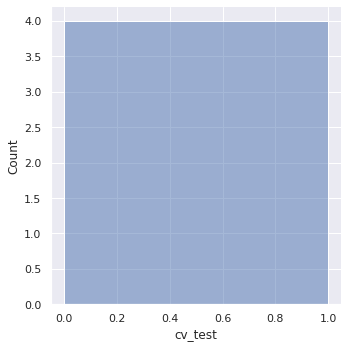

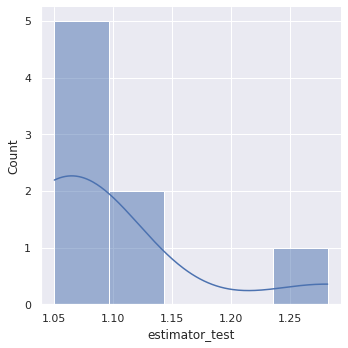

In [27]:
dict = {'cv_test': cv_test, 'estimator_test': estimator_test}
tests = pd.DataFrame(dict)
tests.index
sns.set_theme(style="darkgrid")
sns.displot(data=tests, x="cv_test",kde=True)
sns.displot(data=tests, x="estimator_test",kde=True)


In [28]:
tests.describe()

,cv_test,estimator_test
count,4.0,8.000000
mean,0.5,1.094467
std,0.0,0.079106
min,0.5,1.050642
25%,0.5,1.053488
50%,0.5,1.054952
75%,0.5,1.100572
max,0.5,1.282044


In [29]:
result_fit.describe()

,p_value,mixing_coeffient_est,albedo_est,cross_section_est
count,8.000000,8.000000,8.000000,8.00000
mean,1.094467,0.482375,0.566750,1.54525
std,0.079106,0.108059,0.104947,0.66374
min,1.050642,0.346000,0.404000,0.98000
25%,1.053488,0.368250,0.510500,1.06725
50%,1.054952,0.517500,0.598500,1.21600
75%,1.100572,0.561250,0.634250,1.94675
max,1.282044,0.620000,0.680000,2.56200


In [ ]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_observation")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

In [ ]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_plus_error")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

In [ ]:
data_plot['solar_phase_angle']

In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(data=data_plot, x="mag_observation", kde=True)

In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(data=data_plot, x="model_value", kde=True)

In [ ]:
result_fit.describe()

In [ ]:
result_fit

In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(data=result_fit, x="cross_section_est", kde=True)

In [ ]:
sns.lineplot(data=result_fit, x="mixing_coeffient_est", y="p_value", markers=True, dashes=False)

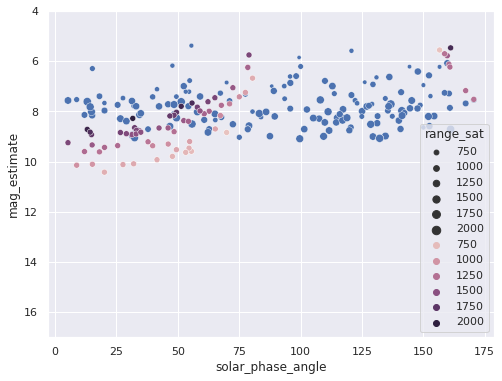

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_estimate", size="range_sat")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", hue="range_sat", markers='s')
ax.set_ylim(17, 4)
plt.show()

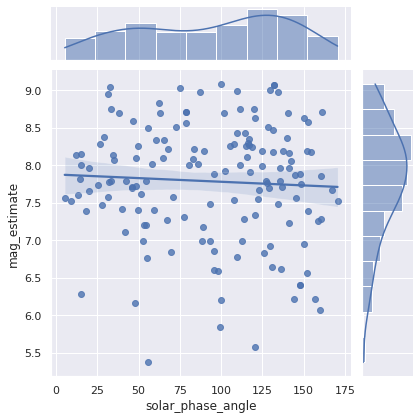

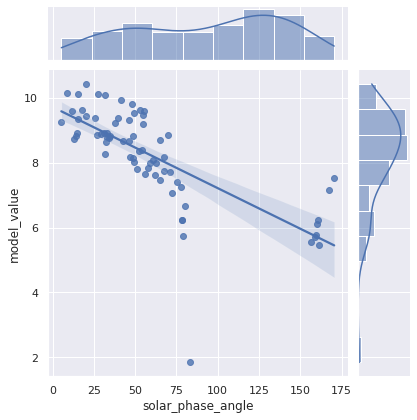

In [31]:
sns.jointplot(data=data_plot, x="solar_phase_angle", y="mag_estimate", kind="reg")
sns.jointplot(data=data_plot, x="solar_phase_angle", y="model_value", kind="reg")
sns.set_context("paper")


In [ ]:
sns.lmplot(x="solar_phase_angle", y="model_value", data=data_plot)